**Alison Glazer**
# Airbnb Smart Pricing - Time Series Analysis
We will use FB Prophet to analyze how Airbnb prices change over time to see if we can extract useful trends to enhance our price suggestions
<br>
The data used covers several years' worth of Airbnb listing data. Each dataset represents the listings as they existed on the date that the data was scraped. For each scrape, I will use the listing prices starting from 1 month ahead of the scrape date through 7 months ahead of the scrape data. This is to get a general sense of seasonal prices - I noticed that for the month immediately following the scrape dates, prices get dropped due to hosts trying to fill their vacancies. This is a separate factor associated with pricing that I would like to address in future work.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Display-Options" data-toc-modified-id="Display-Options-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Display Options</a></span></li><li><span><a href="#Load-and-Clean-the-Data" data-toc-modified-id="Load-and-Clean-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load and Clean the Data</a></span></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean Data</a></span></li><li><span><a href="#Segment-data-by-price" data-toc-modified-id="Segment-data-by-price-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Segment data by price</a></span></li><li><span><a href="#Predict-Average-Price-with-FB-Prophet-on-all-data" data-toc-modified-id="Predict-Average-Price-with-FB-Prophet-on-all-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict Average Price with FB Prophet on all data</a></span></li><li><span><a href="#Model-on-Segmented-Data" data-toc-modified-id="Model-on-Segmented-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model on Segmented Data</a></span><ul class="toc-item"><li><span><a href="#Range-0-to-100-dollars" data-toc-modified-id="Range-0-to-100-dollars-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Range 0 to 100 dollars</a></span></li><li><span><a href="#Range-100-to-200-dollars" data-toc-modified-id="Range-100-to-200-dollars-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Range 100 to 200 dollars</a></span></li><li><span><a href="#$200-and-up" data-toc-modified-id="$200-and-up-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>$200 and up</a></span></li></ul></li><li><span><a href="#Prep-for-Flask-App" data-toc-modified-id="Prep-for-Flask-App-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prep for Flask App</a></span></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sandbox</a></span><ul class="toc-item"><li><span><a href="#Availability" data-toc-modified-id="Availability-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Availability</a></span></li></ul></li></ul></div>

## Import Libraries

In [293]:
# Data
import pandas as pd
import datetime as dt

# Modeling
from fbprophet import Prophet
from datetime import date
import holidays

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from fbprophet.plot import plot_plotly
import plotly.offline as py

# Saving
import pickle

## Display Options

In [255]:
pd.options.display.max_columns = 200

## Load and Clean the Data

In [105]:
# Load in unit IDs of interest
with open('data/lax_X_id.pickle', 'rb') as to_read:
    X_id = pickle.load(to_read)

In [214]:
# Load the calendar data
lax_cal1 = pd.read_csv('data/Los_Angeles/calendar.csv')
lax_cal2 = pd.read_csv('data/Los_Angeles/calendar2.csv')
lax_cal3 = pd.read_csv('data/Los_Angeles/calendar3.csv')
lax_cal4 = pd.read_csv('data/Los_Angeles/calendar4.csv')

In [215]:
print(lax_cal1.shape)
print(lax_cal2.shape)
print(lax_cal3.shape)
print(lax_cal4.shape)

(16444345, 7)
(15766680, 7)
(15769460, 4)
(14438305, 4)


In [216]:
# Convert date to datetime format
lax_cal1.date = pd.to_datetime(lax_cal1.date)
lax_cal2.date = pd.to_datetime(lax_cal2.date)
lax_cal3.date = pd.to_datetime(lax_cal3.date)
lax_cal4.date = pd.to_datetime(lax_cal4.date)

In [219]:
# Trim each dataset to six months from the scrape date
lax_cal1 = lax_cal1[(lax_cal1.date < dt.datetime(2020, 4, 14))
                    & (lax_cal1.date >= dt.datetime(2019, 10, 14))]
lax_cal2 = lax_cal2[(lax_cal2.date < dt.datetime(2019, 10, 14))
                    & (lax_cal2.date >= dt.datetime(2019, 4, 6))]
lax_cal3 = lax_cal3[(lax_cal3.date < dt.datetime(2019, 4, 6))
                    & (lax_cal3.date >= dt.datetime(2018, 10, 8))]
lax_cal4 = lax_cal4[(lax_cal4.date < dt.datetime(2018, 10, 8))
                    & (lax_cal4.date >= dt.datetime(2018, 5, 7))]

In [220]:
# Merge the two datasets
lax_cal = pd.concat([lax_cal1, lax_cal2, lax_cal3, lax_cal4],
                    axis=0,
                    ignore_index=True)

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [221]:
# Delete datasets to clear up memory
del lax_cal1
del lax_cal2
del lax_cal3
del lax_cal4

In [222]:
# Only keep high occupancy rate listings
lax_cal_X = lax_cal[lax_cal.listing_id.isin(list(X_id))]

In [223]:
# Delete to clear up memory
del lax_cal

In [224]:
lax_cal_X

adjusted_price available       date  listing_id  maximum_nights  \
286              $47.00         f 2019-10-14      107970             9.0   
287              $47.00         f 2019-10-15      107970             9.0   
288              $48.00         f 2019-10-16      107970             9.0   
289              $48.00         f 2019-10-17      107970             9.0   
290              $49.00         f 2019-10-18      107970             9.0   
...                 ...       ...        ...         ...             ...   
30345456            NaN         t 2018-05-11    22379373             NaN   
30345457            NaN         t 2018-05-10    22379373             NaN   
30345458            NaN         t 2018-05-09    22379373             NaN   
30345459            NaN         t 2018-05-08    22379373             NaN   
30345460            NaN         t 2018-05-07    22379373             NaN   

          minimum_nights   price  
286                  1.0  $47.00  
287                  1.0  $47.00  
288                  1.0  $48.00  
289                  1.0  $48.00  
290                  1.0  $49.00  
...                  ...     ...  
30345456             NaN  $49.00  
30345457             NaN  $49.00  
30345458             NaN  $49.00  
30345459             NaN  $49.00  
30345460             NaN  $49.00  

[6844931 rows x 7 columns]

In [225]:
# Convert availability column to binary (1 = available)
lax_cal_X['available_bin'] = [
    1 if x == 't' else 0 for x in lax_cal_X.available
]

## Clean Data

Convert price to floats

In [226]:
# Look at datatypes
lax_cal_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6844931 entries, 286 to 30345460
Data columns (total 8 columns):
adjusted_price    object
available         object
date              datetime64[ns]
listing_id        int64
maximum_nights    float64
minimum_nights    float64
price             object
available_bin     int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 470.0+ MB


In [227]:
# Convert price to float
lax_cal_X.price = lax_cal_X['price'].apply(
    lambda s: float(str(s).replace('$', '').replace(',', '')))

In [228]:
# Convert adjusted price to float
lax_cal_X.adjusted_price = lax_cal_X['adjusted_price'].apply(
    lambda s: float(str(s).replace('$', '').replace(',', '')))

In [229]:
lax_cal_X.head()

adjusted_price available       date  listing_id  maximum_nights  \
286            47.0         f 2019-10-14      107970             9.0   
287            47.0         f 2019-10-15      107970             9.0   
288            48.0         f 2019-10-16      107970             9.0   
289            48.0         f 2019-10-17      107970             9.0   
290            49.0         f 2019-10-18      107970             9.0   

     minimum_nights  price  available_bin  
286             1.0   47.0              0  
287             1.0   47.0              0  
288             1.0   48.0              0  
289             1.0   48.0              0  
290             1.0   49.0              0

In [304]:
# Save for later
with open('data/lax_cal_X.pickle', 'wb') as to_write:
    pickle.dump(lax_cal_X, to_write)

In [230]:
# Average all prices by date
avg_df = lax_cal_X.groupby('date')[['price', 'adjusted_price']].mean()

In [231]:
avg_df.reset_index(inplace=True)

In [232]:
# Set up for modeling with Prophet
avg_df = avg_df.rename(columns={'date':'ds','price':'y'})

In [245]:
# Save for later
with open('data/lax_cal_avg_df.pickle', 'wb') as to_write:
    pickle.dump(avg_df, to_write)

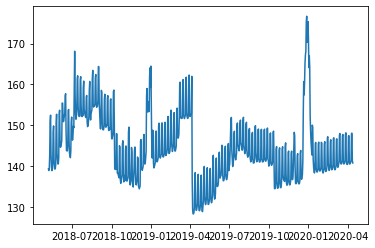

In [233]:
# Look at the data
plt.plot(avg_df.ds,avg_df.y)

## Segment data by price
Try segmenting data by price range to see if it makes a difference in the price time-series models

In [271]:
# Create df averaging for prices with prices from $0-$100 (average across listings to get this base price)
lax_cal_X = lax_cal_X.merge(pd.DataFrame(
    lax_cal_X.groupby('listing_id').price.mean()).reset_index(),
                            on='listing_id').rename(columns={
                                'price_x': 'price',
                                'price_y': 'base_price'
                            })

In [281]:
# Less than $100
avg_0_100 = lax_cal_X[lax_cal_X.base_price < 100].groupby('date')[[
    'price', 'adjusted_price'
]].mean()
avg_0_100.reset_index(inplace=True)
avg_0_100 = avg_0_100.rename(columns={'date': 'ds', 'price': 'y'})

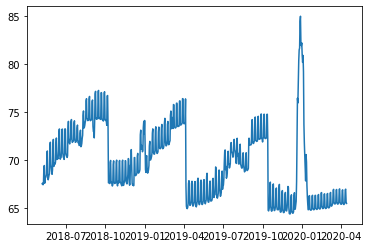

In [282]:
plt.plot(avg_0_100.ds, avg_0_100.y)

In [296]:
# $100-$200
avg_100_200 = lax_cal_X[(lax_cal_X.base_price >= 100)
                        & (lax_cal_X.base_price < 200)].groupby('date')[[
                            'price', 'adjusted_price'
                        ]].mean()
avg_100_200.reset_index(inplace=True)
avg_100_200 = avg_100_200.rename(columns={'date': 'ds', 'price': 'y'})

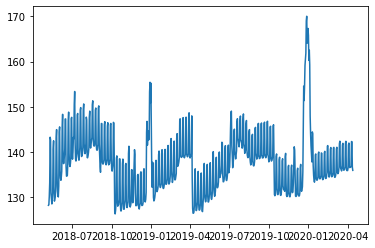

In [297]:
plt.plot(avg_100_200.ds, avg_100_200.y)

In [318]:
# Only 15% of the dataset is higher than 200
# $200 and up
avg_200_up = lax_cal_X[(lax_cal_X.base_price >= 200)].groupby('date')[[
    'price', 'adjusted_price'
]].mean()
avg_200_up.reset_index(inplace=True)
avg_200_up = avg_200_up.rename(columns={'date': 'ds', 'price': 'y'})

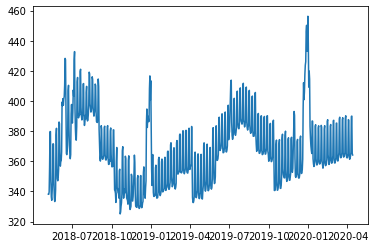

In [319]:
plt.plot(avg_200_up.ds, avg_200_up.y)

## Predict Average Price with FB Prophet on all data

In [338]:
# Set Up Holidays
us_holidays = holidays.UnitedStates(state='CA', years=[2018, 2019, 2020, 2021])
holiday_names = []
holiday_dates = []
for holiday in list(us_holidays.items()):
    holiday_dates.append(holiday[0])
    holiday_names.append(holiday[1])

In [340]:
holidays_time = pd.DataFrame({
    'holiday': holiday_names,
    'ds': holiday_dates,
    'lower_window': -1,
    'upper_window': 1,
})

In [470]:
# Instantiate model and fit to average price data
m = Prophet(yearly_seasonality=True, holidays=holidays_time)
m.add_country_holidays(country_name='US')
m.fit(avg_df)
avg_df.info()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 3 columns):
ds                708 non-null datetime64[ns]
y                 708 non-null float64
adjusted_price    374 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 16.7 KB


In [342]:
# Make future predictions going out 1 year
future = m.make_future_dataframe(periods=365)

In [343]:
# Fill out predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1068 2021-04-09  157.547568  121.585334  193.663825
1069 2021-04-10  157.357078  119.372315  193.321653
1070 2021-04-11  149.340817  112.652691  185.089059
1071 2021-04-12  147.351417  109.743291  182.931613
1072 2021-04-13  146.290456  109.044488  182.847043

In [357]:
# Convert weekly, holidays, and yearly changes to percentages
forecast['weekly_percentage'] = forecast.weekly / forecast.trend
forecast['holiday_percentage'] = forecast.holidays / forecast.trend
forecast['yearly_percentage'] = forecast.yearly / forecast.trend

In [471]:
# Save for making predictions in flask app
forecast.to_csv('lax_forecast.csv')

In [359]:
# Extract relevant info for price estimates
price_change_df = forecast[[
    'ds', 'weekly_percentage', 'holiday_percentage', 'yearly_percentage'
]]

In [363]:
# Save for plotting
with open('data/lax_price_change_df.pickle', 'wb') as to_write:
    pickle.dump(price_change_df, to_write)
price_change_df.to_csv('lax_price_change_df.csv')

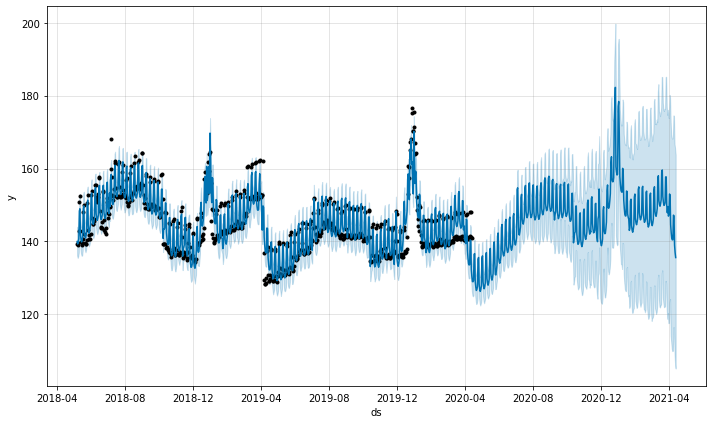

In [241]:
# Plot predictions
fig1 = m.plot(forecast)

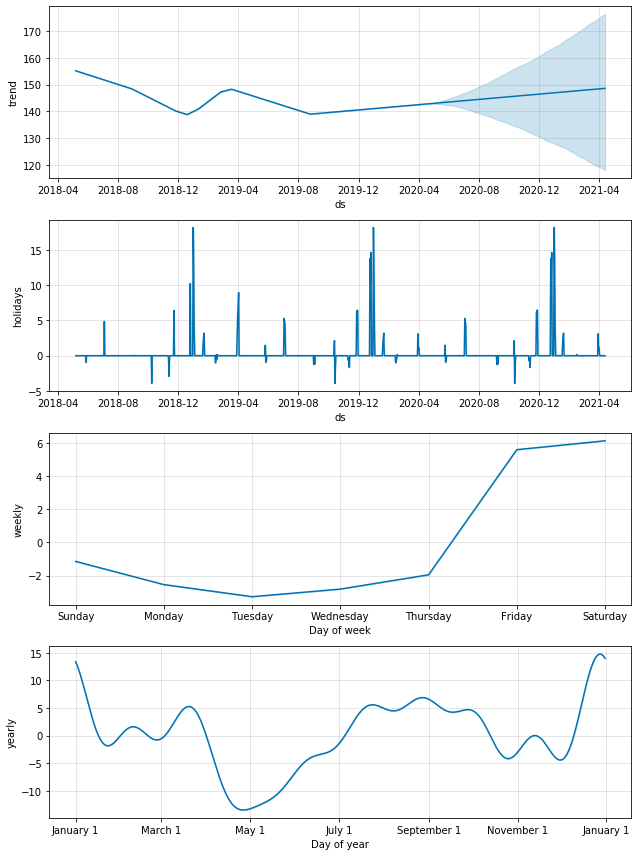

In [242]:
# Plot time-based components
fig2 = m.plot_components(forecast)

In [243]:
# Interactive plot with Plotly
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Model on Segmented Data

### Range 0 to 100 dollars

In [283]:
# Instantiate model
m_0_100 = Prophet(yearly_seasonality=True, holidays=holidays_time)
m_0_100.add_country_holidays(country_name='US')
m_0_100.fit(avg_0_100)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [287]:
# Make future predictions
future_0_100 = m_0_100.make_future_dataframe(periods=365)
forecast_0_100 = m_0_100.predict(future_0_100)

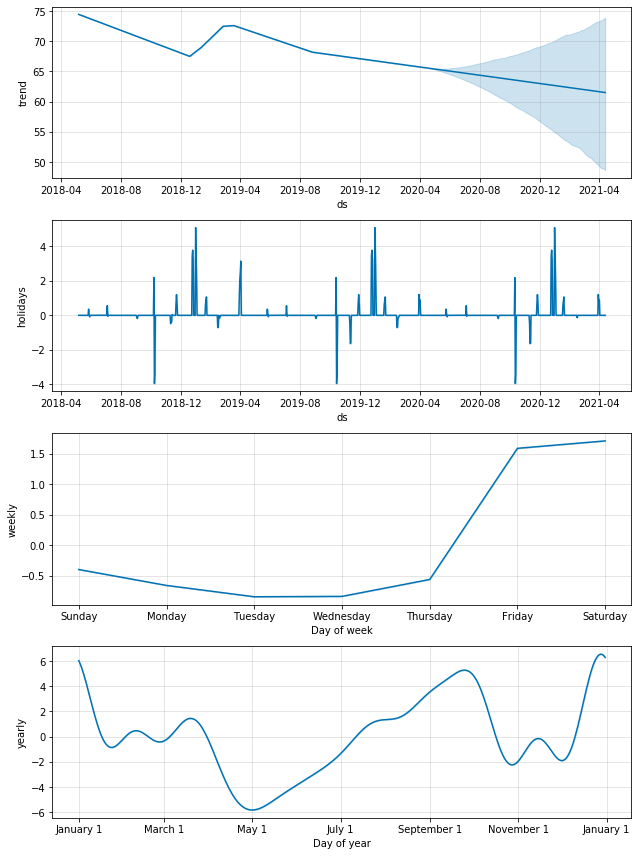

In [292]:
# Plot
fig2 = m_0_100.plot_components(forecast_0_100)

### Range 100 to 200 dollars

In [325]:
# Instantiate model
m_100_200 = Prophet(yearly_seasonality=True, holidays=holidays_time)
m_100_200.add_country_holidays(country_name='US')
m_100_200.fit(avg_100_200)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [326]:
# Make predictions
future_100_200 = m_100_200.make_future_dataframe(periods=365)
forecast_100_200 = m_100_200.predict(future_100_200)

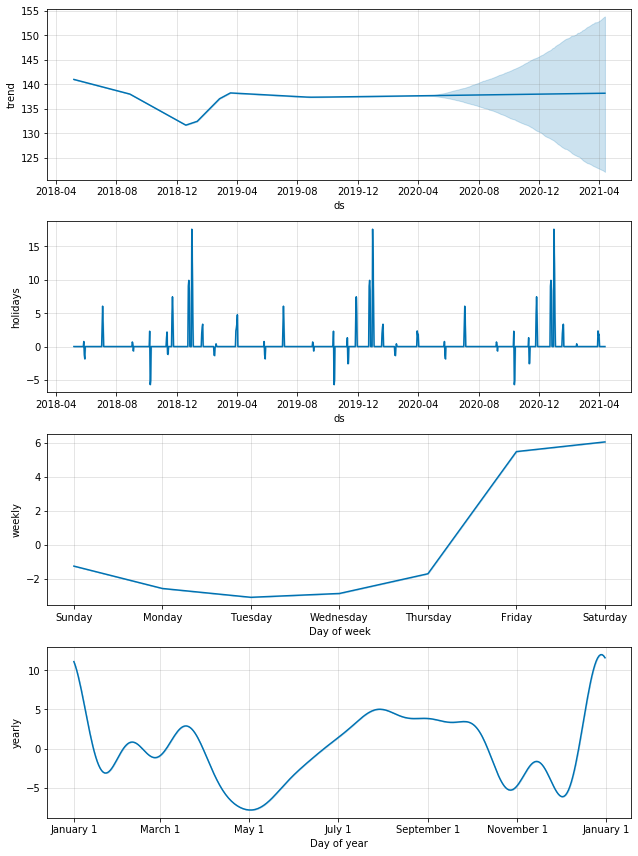

In [328]:
# Plot
fig2 = m_100_200.plot_components(forecast_100_200)

### $200 and up

In [330]:
# Instantiate model, fit to data
m_200_up = Prophet(yearly_seasonality=True, holidays=holidays_time)
m_200_up.add_country_holidays(country_name='US')
m_200_up.fit(avg_200_up)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [331]:
# Make predictions
future_200_up = m_200_up.make_future_dataframe(periods=365)
forecast_200_up = m_200_up.predict(future_200_up)

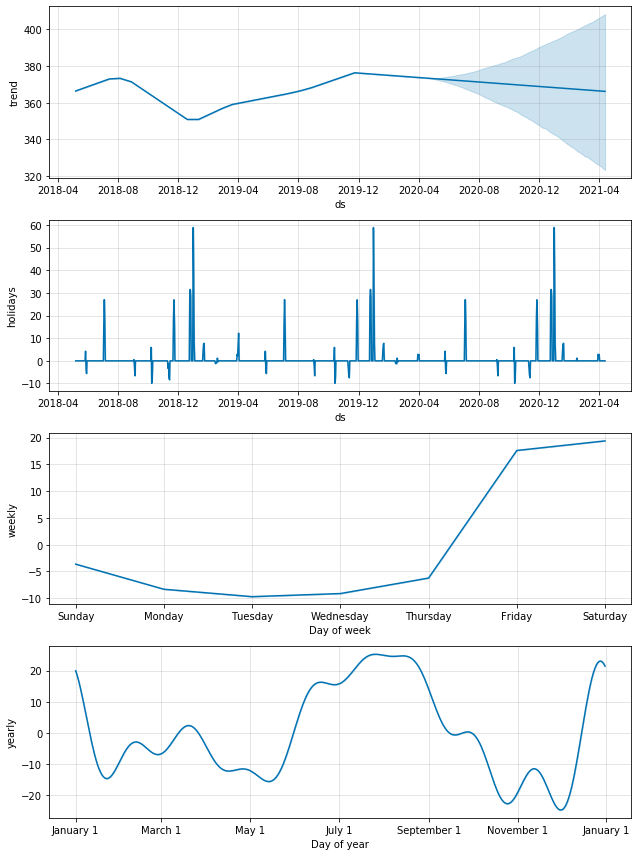

In [333]:
# Plot
fig2 = m_200_up.plot_components(forecast_200_up)

## Prep for Flask App

In [ ]:
# Build function for use in flask app to make time-based predictions given suggested base price
def price_boosters(date_string, price):
    """
    Calculate price boosters for time of year, day of week, and holidays
    """
    date = pd.to_datetime(date_string)
    if date > price_change_df.ds.max():
        date_string = date_string[0:-4] + '2020'
        date = pd.to_datetime(date_string)
    if date < price_change_df.ds.min():
        date_string = date_string[1:-4] + '2019'
        date = pd.to_datetime(date_string)
    boosters = price_change_df[price_change_df.ds == date][[
        'weekly_percentage', 'holiday_percentage', 'yearly_percentage'
    ]].values[0]
    weekly = round(boosters[0] * price, 2)
    holiday = round(boosters[1] * price, 2)
    seasonal = round(boosters[2] * price, 2)
    total = round(price + weekly + holiday + seasonal, 2)
    return weekly, holiday, seasonal, total

## Sandbox
Everything below here is unfinished, but left for those interested. Would like to complete in future work
### Availability
Note that there is no distinction between booked dates and blacked out dates, but we would like to get an idea of whether there is seasonality around the number of listings available

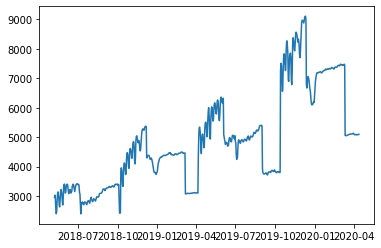

In [234]:
plt.plot(lax_cal_X.groupby('date')['available_bin'].sum())